In [19]:
import numpy as np

import matplotlib.pyplot as plt

from problem import Problem
from data import DataGen

from parameterized import ParameterizedExplainer

from models import * 
from constants import * 


import torch

np.random.seed(0)
torch.manual_seed(0)

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

def eval_models():     
    param_cost = []
    two_cost = [] 
    e2e_low = []
    e2e_high = [] 
    e2e_mid = [] 
    cross_costs_mult = []

    for c, o in zip(model.all_cross_costs, model.all_ordered):
        cross_cost = c[1][0].item()
        cross_costs_mult.append(cross_cost) 

        pred = model.predict(X_test, cross_cost)
        cost = problem_.fulfilment_loss(pred, Y_test, c, o).item()
        param_cost.append(cost)

        ts = two_stage_forecast(X_test)
        cost_two_stage = problem_.fulfilment_loss(ts, Y_test, c, o).item()
        two_cost.append(cost_two_stage)

        # e2 = end_to_end_forecast_low(X_test)
        # e2e_cost_low = problem_.fulfilment_loss(e2, Y_test, c, o).item()
        # e2e_low.append(e2e_cost_low)

        e2 = end_to_end_forecast_high(X_test)
        e2e_cost_high = problem_.fulfilment_loss(e2, Y_test, c, o).item()
        e2e_high.append(e2e_cost_high)

        e2 = end_to_end_forecast_mid(X_test)
        e2e_cost_mid = problem_.fulfilment_loss(e2, Y_test, c, o).item()
        e2e_mid.append(e2e_cost_mid)
        
    return cross_costs_mult, param_cost, two_cost, e2e_high, e2e_mid


In [2]:

n_nodes = 5
n_features = 5

h = 1
b = 10
H = torch.tensor([h for i in range(n_nodes)], device=DEVICE)
B = torch.tensor([b for i in range(n_nodes)], device=DEVICE)  

problem_ = Problem(H, B, n_nodes)

n_data = 1000
n_test = 1000
data_generator = DataGen(n_features, n_nodes)
X_train, Y_train, X_test, Y_test = data_generator.get_test_train(n_data, n_test)


In [3]:
EPOCHS = 3000

print("training mse")
two_stage_forecast = train_two_stage(problem_, X_train, Y_train, X_test, Y_test, EPOCHS=EPOCHS)


training mse
epoch  0 test cost:  3.6585803723335264
epoch  50 test cost:  3.0985209560394287
epoch  100 test cost:  3.1166310358047484


In [55]:
class Forecast2(nn.Module):
    def __init__(self, n_features, n_demands):
        super(Forecast2, self).__init__()
    
        self.linear1 = nn.Linear(n_features, 1000)
        self.linear2 = nn.Linear(1000, n_demands)

    def forward(self, x): 
        f = F.relu(self.linear1(x))
        f = F.relu(self.linear2(f))
        return f
    
def train_task_loss_(problem_, X_train, Y_train, X_test, Y_test, cross_costs, cross_costs_ordered, EPOCHS = 200):   
    n_features = X_train.shape[1]
    n_nodes = Y_train.shape[1]
    forecast = Forecast2(n_features, n_nodes)
    forecast = forecast.to(DEVICE)
    
    best_error = 100000
    optimizer_task = optim.Adam(forecast.parameters(), lr=1e-4)
    criterion = nn.MSELoss()

    all_errs = []
    all_test_errs = []
    batch_size = 50
    for epoch in range(EPOCHS):  # loop over the dataset multiple times
        for i in range(0, Y_train.size()[0], batch_size):
            d = Y_train[i:i+batch_size:]
            inp = X_train[i:i+batch_size,:]

            optimizer_task.zero_grad()

            f = forecast(inp)

            error = problem_.fulfilment_loss(f, d, cross_costs, cross_costs_ordered) 

            error.backward()
            optimizer_task.step()

            all_errs.append(error.item())
            
        if epoch % 20 == 0:
            # test_cost = problem_.evaluate(forecast, X_test, Y_test)[1]
            test_cost = problem_.fulfilment_loss(forecast(X_test), Y_test, cross_costs, cross_costs_ordered).item()
            print("epoch ", epoch, "test cost: ", test_cost)
            if best_error > test_cost: 
                best_error = test_cost
                best_model_state = copy.deepcopy(forecast.state_dict())
            else: 
                forecast.load_state_dict(best_model_state)
                forecast.eval()
                return forecast
    forecast.load_state_dict(best_model_state)
    forecast.eval()
    return forecast

# print("task-loss")
# c1 = problem_.all_cross_costs[-1]
# c2 = problem_.all_ordered[-1]
# end_to_end_forecast_high = train_task_loss_(problem_, X_train, Y_train, X_test, Y_test, c1, c2, EPOCHS=500)

In [57]:
print("task-loss")
# end_to_end_f = []
for _ in range(5):
    for i in range(0, 100, 9):
        c1 = problem_.all_cross_costs[i]
        c2 = problem_.all_ordered[i]
        m = train_task_loss_(problem_, X_train, Y_train, X_test, Y_test, c1, c2, EPOCHS=200)
        end_to_end_f.append(m)
        print("cross cost:", i)

task-loss
epoch  0 test cost:  1.1693980693817139
epoch  20 test cost:  0.41649550199508667
epoch  40 test cost:  0.4071629047393799
epoch  60 test cost:  0.4118356704711914
cross cost: 0
epoch  0 test cost:  2.520876169204712
epoch  20 test cost:  0.5971160531044006
epoch  40 test cost:  0.5628525614738464
epoch  60 test cost:  0.5574856400489807
epoch  80 test cost:  0.5576457381248474
cross cost: 9
epoch  0 test cost:  2.3972349166870117
epoch  20 test cost:  0.7140312790870667
epoch  40 test cost:  0.6859592795372009
epoch  60 test cost:  0.6812168955802917
epoch  80 test cost:  0.6785297989845276
epoch  100 test cost:  0.6760981678962708
epoch  120 test cost:  0.675151526927948
epoch  140 test cost:  0.681736946105957
cross cost: 18
epoch  0 test cost:  2.7178268432617188
epoch  20 test cost:  0.8306316137313843
epoch  40 test cost:  0.7978360652923584
epoch  60 test cost:  0.7772244811058044
epoch  80 test cost:  0.778558611869812
cross cost: 27
epoch  0 test cost:  5.58326768875

In [6]:
print("training parameterized model")
model = ParameterizedExplainer(data_generator.data_model, X_train, Y_train, problem_).to(DEVICE)
model.train(X_test, Y_test, EPOCHS = 1500, lr=1e-4)

training parameterized model
epoch  0 test cost:  6.834701089859009 100000
epoch  50 test cost:  2.5283490961790083 6.834701089859009
epoch  100 test cost:  1.2401316440105439 2.5283490961790083
epoch  150 test cost:  1.0620318034291267 1.2401316440105439
epoch  200 test cost:  0.9902727290987968 1.0620318034291267
epoch  250 test cost:  0.9501037409901619 0.9902727290987968
epoch  300 test cost:  0.9224588686227798 0.9501037409901619
epoch  350 test cost:  0.902473132610321 0.9224588686227798
epoch  400 test cost:  0.8901792350411415 0.902473132610321
epoch  450 test cost:  0.8812473472952843 0.8901792350411415
epoch  500 test cost:  0.8683323723077774 0.8812473472952843
epoch  550 test cost:  0.8599399891495705 0.8683323723077774
epoch  600 test cost:  0.8519521835446358 0.8599399891495705
epoch  650 test cost:  0.8469759377837182 0.8519521835446358
epoch  700 test cost:  0.8413689395785332 0.8469759377837182
epoch  750 test cost:  0.8392387205362319 0.8413689395785332
epoch  800 tes

KeyboardInterrupt: 

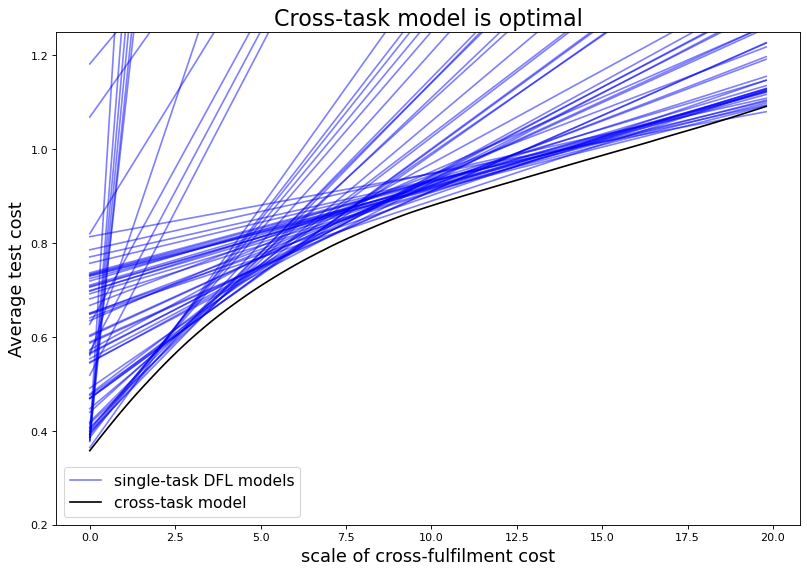

In [59]:
plt.figure(figsize=(12, 8), dpi=80)

for e2e_model in end_to_end_f:
    res, _ = problem_.evaluate(e2e_model, X_test, Y_test) 
    plt.plot(cross_costs_mult, res, color = 'blue', alpha = 0.5)
plt.plot(cross_costs_mult, res, color = 'blue', alpha = 0.5, label = 'single-task DFL models')
plt.plot(cross_costs_mult, param_cost, color = "black", label = 'cross-task model')
plt.legend(fontsize=14) 

plt.xlabel("scale of cross-fulfilment cost", fontsize=16)
plt.ylabel("Average test cost", fontsize=16)
plt.title('Cross-task model is optimal', fontsize=20)
plt.ylim(0.2, 1.25)
# plt.savefig('results/cross_optimal.png')

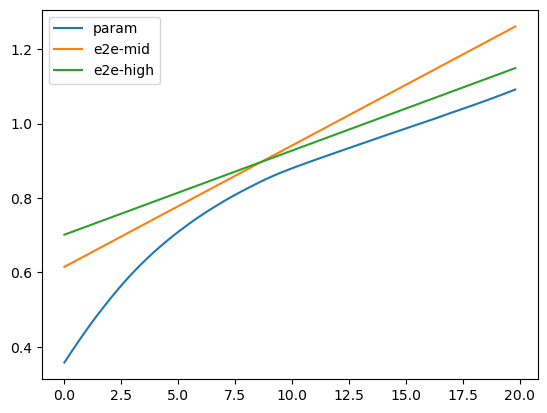

In [20]:
cross_costs_mult, param_cost, two_cost, e2e_high, e2e_mid = eval_models()
np.save("results/parameterized_model_costs.npy", param_cost)
np.save("results/e2e_high_model_costs.npy", e2e_high)
np.save("results/e2e_mid_model_costs.npy", e2e_mid)
np.save("results/two_stage.npy", two_cost)

plt.plot(cross_costs_mult, param_cost, label = 'param')
# plt.plot(cross_costs_mult, two_cost, label = 'two-stage')
# plt.plot(cross_costs_mult, e2e_low, label = 'e2e-low')
plt.plot(cross_costs_mult, e2e_mid, label = 'e2e-mid')
plt.plot(cross_costs_mult, e2e_high, label = 'e2e-high')
plt.legend()
# plt.savefig('results/plot.png')

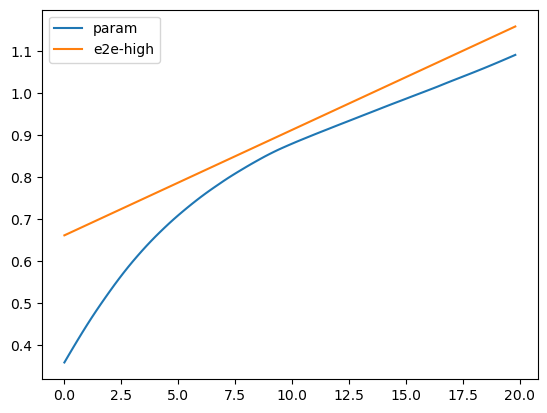

In [8]:
cross_costs_mult, param_cost, two_cost, e2e_high = eval_models()
np.save("results/parameterized_model_costs.npy", param_cost)
np.save("results/e2e_high_model_costs.npy", e2e_high)
np.save("results/two_stage.npy", two_cost)

plt.plot(cross_costs_mult, param_cost, label = 'param')
# plt.plot(cross_costs_mult, two_cost, label = 'two-stage')
# plt.plot(cross_costs_mult, e2e_low, label = 'e2e-low')
plt.plot(cross_costs_mult, e2e_mid, label = 'e2e-mid')
plt.plot(cross_costs_mult, e2e_high, label = 'e2e-high')
plt.legend()
# plt.savefig('results/plot.png')